## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from influxdb_client import InfluxDBClient

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [4]:
df = pd.read_csv("dataframe_11g_5m.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
n_days = 11
df = df.drop(columns=['humidity', 'temperature', 'people'])
df

,pressure
time,
2020-07-07 13:30:00+00:00,1019.5
2020-07-07 13:35:00+00:00,1019.5
2020-07-07 13:40:00+00:00,1019.5
2020-07-07 13:45:00+00:00,1019.5
2020-07-07 13:50:00+00:00,1019.5
...,...
2020-07-18 13:05:00+00:00,1018.4
2020-07-18 13:10:00+00:00,1018.4
2020-07-18 13:15:00+00:00,1018.4


# Fill NaN values

In [5]:
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')

In [6]:
points_per_day = int(len(df)/n_days) 
points_per_day

288

In [7]:
print(df['pressure'].isnull().sum())

0


# Split the dataset

In [8]:
# divide in train e test
#size = int(len(df)*0.8)
size = len(df)-points_per_day
df_train, df_test = df.iloc[:size], df.iloc[size:]

# Dickey–Fuller test

In [10]:
sts.adfuller(df.pressure) # non stazionaria

(-1.9304460578334657,
 0.3178766249543116,
 24,
 3143,
 {'1%': -3.432432293604288,
  '5%': -2.862460029008544,
  '10%': -2.5672597530168955},
 -2794.548696586955)

## The LLR Test

In [11]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Auto Correlation Function (ACF)

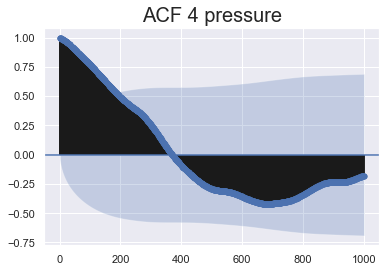

In [12]:
sgt.plot_acf(df.pressure, zero = False, lags = 1000)
plt.title("ACF 4 pressure", size = 20)
plt.show()

## Partial Auto Correlation Function (PACF)

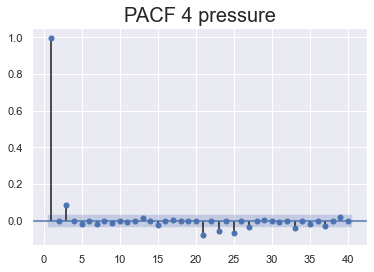

In [13]:
sgt.plot_pacf(df.pressure, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 pressure", size = 20)
plt.show()

# Pressure

In [15]:
start_date = df_test.index[0]
end_date = df_test.index[points_per_day-1]

## AR

In [17]:
print("AR(1)")
model_p_ar_1 = SARIMAX(df_train.pressure, order=(1,0,0))
results_p_ar_1 = model_p_ar_1.fit()
print(results_p_ar_1.summary())

print("AR(2)") 
model_p_ar_2 = SARIMAX(df_train.pressure, order=(2,0,0))
results_p_ar_2 = model_p_ar_2.fit()
print(results_p_ar_2.summary())

print("AR(3)") 
model_p_ar_3 = SARIMAX(df_train.pressure, order=(3,0,0))
results_p_ar_3 = model_p_ar_3.fit()
print(results_p_ar_3.summary())

print("AR(4)") #PARAMETRI NON SIGNIFICATIVI
model_p_ar_4 = ARIMA(df_train.pressure, order=(4,0,0))
results_p_ar_4 = model_p_ar_4.fit()
print(results_p_ar_4.summary())

print("AR(5)") #PARAMETRI NON SIGNIFICATIVI
model_p_ar_5 = ARIMA(df_train.pressure, order=(5,0,0))
results_p_ar_5 = model_p_ar_5.fit()
print(results_p_ar_5.summary())

AR(1)
                               SARIMAX Results                                
Dep. Variable:               pressure   No. Observations:                 2880
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1227.205
Date:                Sun, 19 Jul 2020   AIC                          -2450.410
Time:                        23:34:03   BIC                          -2438.479
Sample:                    07-07-2020   HQIC                         -2446.110
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   2.46e-08   4.07e+07      0.000       1.000       1.000
sigma2         0.0249      0.000    242.573      0.000       0.025       0.025
Ljung-Box (Q):                       65.99   J

In [18]:
print("AR(1):  \t LL = ", results_p_ar_1.llf, "\t AIC = ", results_p_ar_1.aic)
print("AR(2):  \t LL = ", results_p_ar_2.llf, "\t AIC = ", results_p_ar_2.aic)
print("AR(3):  \t LL = ", results_p_ar_3.llf, "\t AIC = ", results_p_ar_3.aic)

AR(1):  	 LL =  1227.205051410468 	 AIC =  -2450.410102820936
AR(2):  	 LL =  1227.1864564734665 	 AIC =  -2448.372912946933
AR(3):  	 LL =  1229.9667090383314 	 AIC =  -2451.9334180766627


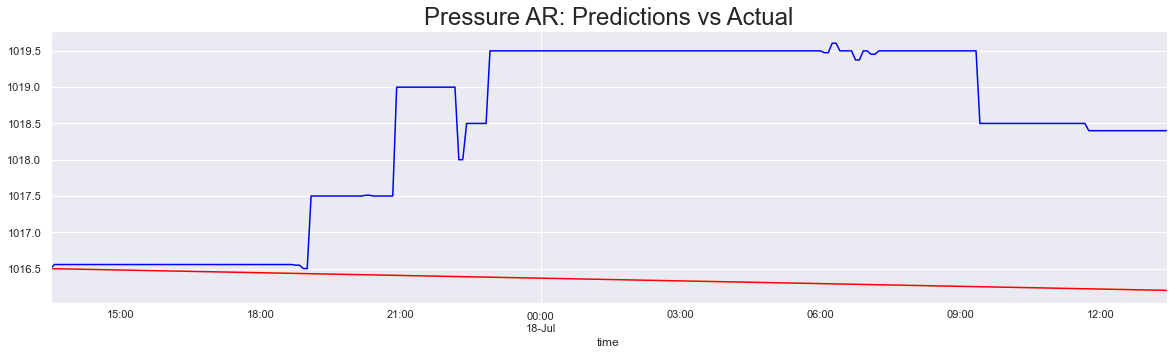

MAE 2.0753002891997676
MSE 5.859209193738033


In [19]:
df_pred = results_p_ar_3.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[start_date:end_date].plot(color = "blue")
plt.title("Pressure AR: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.pressure[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.pressure[start_date:end_date], df_pred[start_date:end_date])))

## MA

In [21]:
model_p_ma_1 = ARMA(df_train.pressure, order=(0,1))
results_p_ma_1 = model_p_ma_1.fit()
print(results_p_ma_1.summary())

model_p_ma_2 = ARMA(df_train.pressure, order=(0,2))
results_p_ma_2 = model_p_ma_2.fit(start_ar_lags=100)
print(results_p_ma_2.summary())

model_p_ma_3 = ARMA(df_train.pressure, order=(0,3))
results_p_ma_3 = model_p_ma_3.fit()
print(results_p_ma_3.summary())

model_p_ma_4 = ARMA(df_train.pressure, order=(0,4))
results_p_ma_4 = model_p_ma_4.fit(start_ar_lags=100)
print(results_p_ma_4.summary())

model_p_ma_5 = ARMA(df_train.pressure, order=(0,5))
results_p_ma_5 = model_p_ma_5.fit()
print(results_p_ma_5.summary())

model_p_ma_6 = ARMA(df_train.pressure, order=(0,6))
results_p_ma_6 = model_p_ma_6.fit(start_ar_lags=100)
print(results_p_ma_6.summary())

model_p_ma_7 = ARMA(df_train.pressure, order=(0,7))
results_p_ma_7 = model_p_ma_7.fit()
print(results_p_ma_7.summary())

                              ARMA Model Results                              
Dep. Variable:               pressure   No. Observations:                 2880
Model:                     ARMA(0, 1)   Log Likelihood               -5166.174
Method:                       css-mle   S.D. of innovations              1.454
Date:                Sun, 19 Jul 2020   AIC                          10338.348
Time:                        23:37:21   BIC                          10356.245
Sample:                    07-07-2020   HQIC                         10344.799
                         - 07-17-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1019.1449      0.053   1.92e+04      0.000    1019.041    1019.249
ma.L1.pressure     0.9551      0.004    255.202      0.000       0.948       0.962
                                    

                              ARMA Model Results                              
Dep. Variable:               pressure   No. Observations:                 2880
Model:                     ARMA(0, 6)   Log Likelihood                -871.540
Method:                       css-mle   S.D. of innovations              0.327
Date:                Sun, 19 Jul 2020   AIC                           1759.080
Time:                        23:37:27   BIC                           1806.804
Sample:                    07-07-2020   HQIC                          1776.282
                         - 07-17-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1019.1432      0.075   1.36e+04      0.000    1018.996    1019.290
ma.L1.pressure     1.9626      0.020     98.839      0.000       1.924       2.002
ma.L2.pressure     2.6288      0.038

In [22]:
print("MA(1):  \t LL = ", results_p_ma_1.llf, "\t AIC = ", results_p_ma_1.aic)
print("MA(2):  \t LL = ", results_p_ma_2.llf, "\t AIC = ", results_p_ma_2.aic)
print("MA(3):  \t LL = ", results_p_ma_3.llf, "\t AIC = ", results_p_ma_3.aic)
print("MA(4):  \t LL = ", results_p_ma_4.llf, "\t AIC = ", results_p_ma_4.aic)
print("MA(5):  \t LL = ", results_p_ma_5.llf, "\t AIC = ", results_p_ma_5.aic)
print("MA(6):  \t LL = ", results_p_ma_6.llf, "\t AIC = ", results_p_ma_6.aic)
print("MA(7):  \t LL = ", results_p_ma_7.llf, "\t AIC = ", results_p_ma_7.aic)

MA(1):  	 LL =  -5166.174176296827 	 AIC =  10338.348352593654
MA(2):  	 LL =  -3626.5187987258514 	 AIC =  7261.037597451703
MA(3):  	 LL =  -2593.1114668634655 	 AIC =  5196.222933726931
MA(4):  	 LL =  -1817.1375615894017 	 AIC =  3646.2751231788034
MA(5):  	 LL =  -1301.93676078121 	 AIC =  2617.87352156242
MA(6):  	 LL =  -871.5399890255239 	 AIC =  1759.0799780510479
MA(7):  	 LL =  -579.8068300828199 	 AIC =  1177.6136601656399


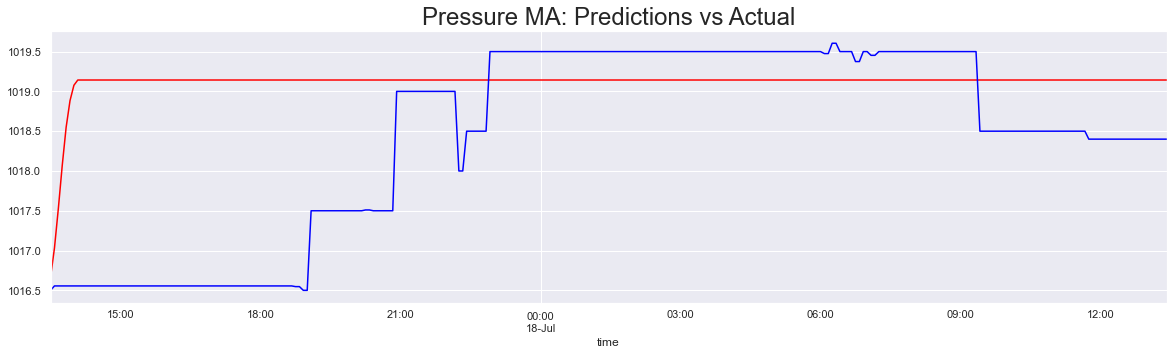

MAE 1.0010934519130064
MSE 1.8247636231863023


In [23]:
df_pred = results_p_ma_7.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[start_date:end_date].plot(color = "blue")
plt.title("Pressure MA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.pressure[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.pressure[start_date:end_date], df_pred[start_date:end_date])))

## ARMA

In [24]:
print("\nARMA(1,1)") #NON SIGNIFICATIVO
results_p_ar_1_ma_1 = ARMA(df_train.pressure, order=(1,1)).fit()
print(results_p_ar_1_ma_1.summary())

print("\nARMA(2,1)") 
results_p_ar_2_ma_1 = ARMA(df_train.pressure, order=(2,1)).fit()
print(results_p_ar_2_ma_1.summary())

print("\nARMA(1,2)") #NON SIGNIFICATIVO
results_p_ar_1_ma_2 = ARMA(df_train.pressure, order=(1,2)).fit()
print(results_p_ar_1_ma_2.summary())

print("\nARMA(2,2)") #NON SIGNIFICATIVO
results_p_ar_2_ma_2 = ARMA(df_train.pressure, order=(2,2)).fit()
print(results_p_ar_2_ma_2.summary())

print("\nARMA(3,1)") #NON SIGNIFICATIVO
results_p_ar_3_ma_1 = ARMA(df_train.pressure, order=(3,1)).fit()
print(results_p_ar_3_ma_1.summary())

print("\nARMA(1,3)") #NON SIGNIFICATIVO
results_p_ar_1_ma_3 = ARMA(df_train.pressure, order=(1,3)).fit()
print(results_p_ar_1_ma_3.summary())

print("\nARMA(3,2)") #NON SIGNIFICATIVO
results_p_ar_3_ma_2 = ARMA(df_train.pressure, order=(3,2)).fit()
print(results_p_ar_3_ma_2.summary())

print("\nARMA(2,3)") 
results_p_ar_2_ma_3 = ARMA(df_train.pressure, order=(2,3)).fit()
print(results_p_ar_2_ma_3.summary())

print("\nARMA(3,3)") #NON SIGNIFICATIVO
results_p_ar_3_ma_3 = ARMA(df_train.pressure, order=(3,3)).fit()
print(results_p_ar_3_ma_3.summary())


ARMA(1,1)
                              ARMA Model Results                              
Dep. Variable:               pressure   No. Observations:                 2880
Model:                     ARMA(1, 1)   Log Likelihood                1275.576
Method:                       css-mle   S.D. of innovations              0.155
Date:                Sun, 19 Jul 2020   AIC                          -2543.152
Time:                        23:38:59   BIC                          -2519.290
Sample:                    07-07-2020   HQIC                         -2534.551
                         - 07-17-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1018.8154      1.432    711.258      0.000    1016.008    1021.623
ar.L1.pressure     0.9983      0.001   1045.769      0.000       0.996       1.000
ma.L1.pressure     0.0009

                              ARMA Model Results                              
Dep. Variable:               pressure   No. Observations:                 2880
Model:                     ARMA(1, 3)   Log Likelihood                1285.594
Method:                       css-mle   S.D. of innovations              0.155
Date:                Sun, 19 Jul 2020   AIC                          -2559.189
Time:                        23:39:03   BIC                          -2523.395
Sample:                    07-07-2020   HQIC                         -2546.287
                         - 07-17-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1018.7765      1.504    677.594      0.000    1015.830    1021.723
ar.L1.pressure     0.9985      0.001   1152.806      0.000       0.997       1.000
ma.L1.pressure     0.0006      0.019

In [25]:
print("ARMA(2,1):  \t LL = ", results_p_ar_2_ma_1.llf, "\t AIC = ", results_p_ar_2_ma_1.aic)
print("ARMA(2,3):  \t LL = ", results_p_ar_2_ma_3.llf, "\t AIC = ", results_p_ar_2_ma_3.aic)

ARMA(2,1):  	 LL =  1277.4914938408688 	 AIC =  -2544.9829876817375
ARMA(2,3):  	 LL =  1290.8924215210095 	 AIC =  -2567.784843042019


In [26]:
print("\nARMA(2,1) vs ARMA(2,3) ",LLR_test(results_p_ar_2_ma_1, results_p_ar_2_ma_3, DF=1))


ARMA(2,1) vs ARMA(2,3)  0.0


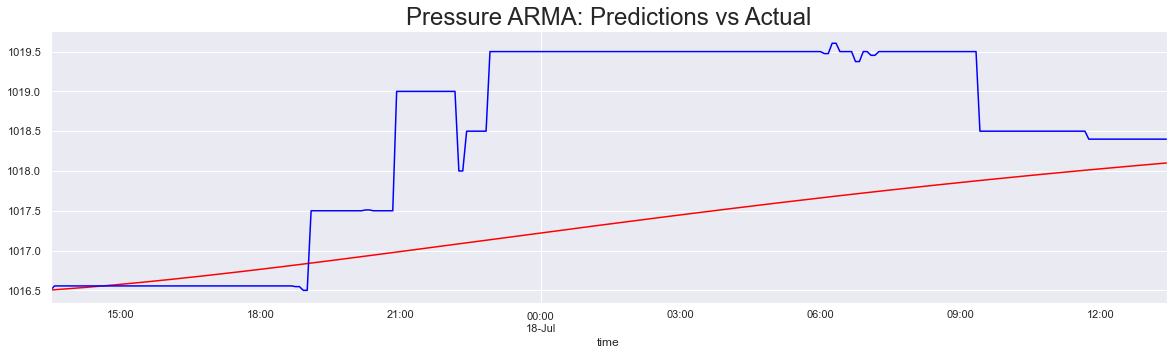

MAE 1.1598959633583397
MSE 2.062503927096005


In [27]:
df_pred = results_p_ar_2_ma_3.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[start_date:end_date].plot(color = "blue")
plt.title("Pressure ARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.pressure[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.pressure[start_date:end_date], df_pred[start_date:end_date])))

## ARIMA

In [28]:
print("\nARIMA(1,1,1)") 
results_p_ar_1_i_1_ma_1 = SARIMAX(df_train.pressure, order=(1,1,1)).fit()
print(results_p_ar_1_i_1_ma_1.summary())

print("\nARIMA(2,1,1)")
results_p_ar_2_i_1_ma_1 = SARIMAX(df_train.pressure, order=(2,1,1)).fit()
print(results_p_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,1,2)") #NON SIGNIFICATIVO
results_p_ar_1_i_1_ma_2 = SARIMAX(df_train.pressure, order=(1,1,2)).fit()
print(results_p_ar_1_i_1_ma_2.summary())

print("\nARIMA(1,1,3)") #NON SIGNIFICATIVO
results_p_ar_1_i_1_ma_3 = SARIMAX(df_train.pressure, order=(1,1,3)).fit()
print(results_p_ar_1_i_1_ma_3.summary())

print("\nARIMA(3,1,1)") 
results_p_ar_3_i_1_ma_1 = SARIMAX(df_train.pressure, order=(3,1,1)).fit()
print(results_p_ar_3_i_1_ma_1.summary())

print("\nARIMA(3,1,2)") #NON SIGNIFICATIVO
results_p_ar_3_i_1_ma_2 = SARIMAX(df_train.pressure, order=(3,1,2)).fit()
print(results_p_ar_3_i_1_ma_2.summary())

print("\nARIMA(3,1,3)") #NON SIGNIFICATIVO
results_p_ar_3_i_1_ma_3 = SARIMAX(df_train.pressure, order=(3,1,3)).fit()
print(results_p_ar_3_i_1_ma_3.summary())


############################

print("\nARIMA(1,2,1)")
results_p_ar_1_i_2_ma_1 = SARIMAX(df_train.pressure, order=(1,2,1)).fit()
print(results_p_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)")
results_p_ar_2_i_2_ma_1 = SARIMAX(df_train.pressure, order=(2,2,1)).fit()
print(results_p_ar_2_i_2_ma_1.summary())

print("\nARIMA(1,2,2)") #NON SIGNIFICATIVO
results_p_ar_1_i_2_ma_2 = SARIMAX(df_train.pressure, order=(1,2,2)).fit()
print(results_p_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)") #NON SIGNIFICATIVO
results_p_ar_2_i_2_ma_2 = SARIMAX(df_train.pressure, order=(2,2,2)).fit()
print(results_p_ar_2_i_2_ma_2.summary())


print("\nARIMA(1,2,3)") #NON SIGNIFICATIVO
results_p_ar_1_i_2_ma_3 = SARIMAX(df_train.pressure, order=(1,2,3)).fit()
print(results_p_ar_1_i_2_ma_3.summary())

print("\nARIMA(3,2,1)") #NON SIGNIFICATIVO
results_p_ar_3_i_2_ma_1 = SARIMAX(df_train.pressure, order=(3,2,1)).fit()
print(results_p_ar_3_i_2_ma_1.summary())

print("\nARIMA(3,2,2)") #NON SIGNIFICATIVO
results_p_ar_3_i_2_ma_2 = SARIMAX(df_train.pressure, order=(3,2,2)).fit()
print(results_p_ar_3_i_2_ma_2.summary())

print("\nARIMA(3,2,3)") #NON SIGNIFICATIVO
results_p_ar_3_i_2_ma_3 = SARIMAX(df_train.pressure, order=(3,2,3)).fit()
print(results_p_ar_3_i_2_ma_3.summary())



ARIMA(1,1,1)
                               SARIMAX Results                                
Dep. Variable:               pressure   No. Observations:                 2880
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1276.593
Date:                Sun, 19 Jul 2020   AIC                          -2547.186
Time:                        23:40:00   BIC                          -2529.291
Sample:                    07-07-2020   HQIC                         -2540.736
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       5.917e-08   4.34e-14   1.36e+06      0.000    5.92e-08    5.92e-08
ma.L1      -4.896e-08   4.43e-14   -1.1e+06      0.000    -4.9e-08    -4.9e-08
sigma2         0.0241   9.65e-05    24

                               SARIMAX Results                                
Dep. Variable:               pressure   No. Observations:                 2880
Model:               SARIMAX(3, 1, 2)   Log Likelihood                1287.852
Date:                Sun, 19 Jul 2020   AIC                          -2563.703
Time:                        23:40:02   BIC                          -2527.912
Sample:                    07-07-2020   HQIC                         -2550.802
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       3.062e-07   1.77e-07      1.725      0.085   -4.17e-08    6.54e-07
ar.L2         -0.2803      0.146     -1.922      0.055      -0.566       0.005
ar.L3       1.195e-07   7.48e-07      0.160      0.8

                               SARIMAX Results                                
Dep. Variable:               pressure   No. Observations:                 2880
Model:               SARIMAX(2, 2, 2)   Log Likelihood                1283.086
Date:                Sun, 19 Jul 2020   AIC                          -2556.172
Time:                        23:40:11   BIC                          -2526.347
Sample:                    07-07-2020   HQIC                         -2545.421
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0397      1.268      0.031      0.975      -2.446       2.525
ar.L2         -0.0910      0.018     -5.132      0.000      -0.126      -0.056
ma.L1         -1.0384      1.230     -0.844      0.3

In [29]:
print("ARMA(1,1,1):  \t LL = ", results_p_ar_1_i_1_ma_1.llf, "\t AIC = ", results_p_ar_1_i_1_ma_1.aic)
print("ARMA(2,1,1):  \t LL = ", results_p_ar_2_i_1_ma_1.llf, "\t AIC = ", results_p_ar_2_i_1_ma_1.aic)
print("ARMA(3,1,1):  \t LL = ", results_p_ar_3_i_1_ma_1.llf, "\t AIC = ", results_p_ar_3_i_1_ma_1.aic)
print("ARMA(1,2,1):  \t LL = ", results_p_ar_1_i_2_ma_1.llf, "\t AIC = ", results_p_ar_1_i_2_ma_1.aic)
print("ARMA(2,2,1):  \t LL = ", results_p_ar_2_i_2_ma_1.llf, "\t AIC = ", results_p_ar_2_i_2_ma_1.aic)

ARMA(1,1,1):  	 LL =  1276.5930699601174 	 AIC =  -2547.186139920235
ARMA(2,1,1):  	 LL =  1287.3228103588256 	 AIC =  -2566.645620717651
ARMA(3,1,1):  	 LL =  1287.3228103588935 	 AIC =  -2564.645620717787
ARMA(1,2,1):  	 LL =  1271.7320054169618 	 AIC =  -2537.4640108339236
ARMA(2,2,1):  	 LL =  1283.054442063257 	 AIC =  -2558.108884126514


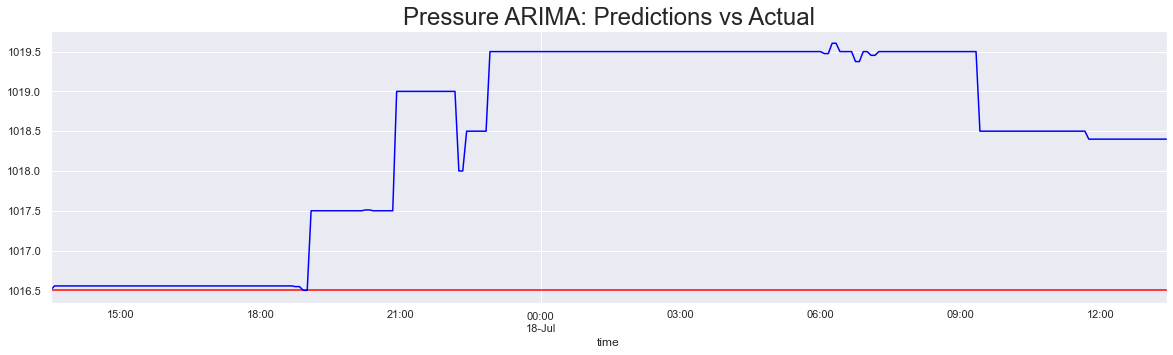

MAE 1.9245671752148046
MSE 5.109396278246925


In [30]:
df_pred = results_p_ar_2_i_1_ma_1.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[start_date:end_date].plot(color = "blue")
plt.title("Pressure ARIMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.pressure[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.pressure[start_date:end_date], df_pred[start_date:end_date])))